In [33]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
import os  # 导入标准库os
import pandas as pd


In [34]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization, concatenate, AveragePooling2D
from keras.utils import np_utils
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import pydot
%matplotlib inline

In [35]:
from tqdm import tqdm
def get_data(folder):
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = scipy.misc.imresize(arr=img_file, size=(60, 80, 3))   #改变图像大小并且隐藏归一化到0-255区间的操作
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

In [36]:
X_train, y_train, z_train = get_data('./input/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('./input/dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)

X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

  0%|          | 0/2499 [00:00<?, ?it/s]/Users/liyanran/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|██████████| 620/620 [00:02<00:00, 245.11it/s]


In [37]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.savefig('./curve.png')


def plot_accuracy_curve(history):
    plt.figure(figsize=(8,8))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    
def plot_loss_curve(history):
    plt.figure(figsize=(8,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')
    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [38]:
import keras
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}
def runKerasCNNAugment(a,b,c,d,e):
    batch_size = 128
    num_classes = len(b[0])
    epochs = 30
    img_rows,img_cols=60,80
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = dict_characters
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1)
    plotKerasLearningCurve()
    plt.show()  
    plot_accuracy_curve(history)
    plt.show()
    plot_loss_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
    
    
    return(model, history)

Epoch 1/30
312/311 [==============================] - 188s 603ms/step - loss: 1.4463 - acc: 0.2535 - val_loss: 1.3952 - val_acc: 0.2509
Epoch 2/30
312/311 [==============================] - 158s 506ms/step - loss: 1.3960 - acc: 0.2517 - val_loss: 1.3819 - val_acc: 0.2493
Epoch 3/30
312/311 [==============================] - 167s 536ms/step - loss: 1.3730 - acc: 0.2974 - val_loss: 1.3186 - val_acc: 0.3571
Epoch 4/30
312/311 [==============================] - 165s 529ms/step - loss: 1.3193 - acc: 0.3621 - val_loss: 1.4032 - val_acc: 0.3132
Epoch 5/30
312/311 [==============================] - 179s 572ms/step - loss: 1.2697 - acc: 0.4014 - val_loss: 1.5262 - val_acc: 0.2493
Epoch 6/30
312/311 [==============================] - 168s 540ms/step - loss: 1.2135 - acc: 0.4348 - val_loss: 1.0832 - val_acc: 0.5022
Epoch 7/30
312/311 [==============================] - 166s 533ms/step - loss: 1.1247 - acc: 0.4816 - val_loss: 1.0826 - val_acc: 0.4403
Epoch 8/30
312/311 [============================

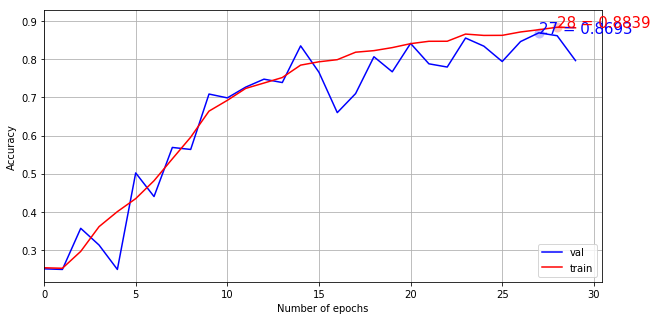

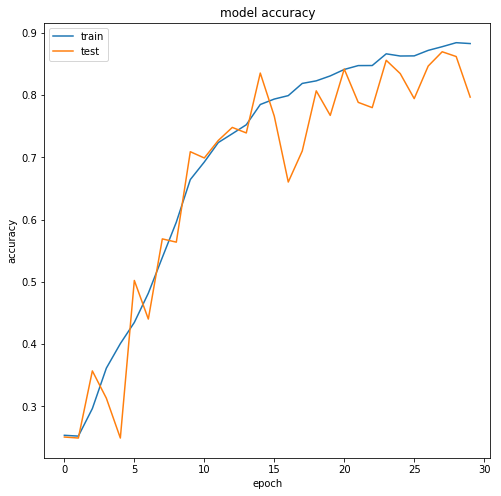

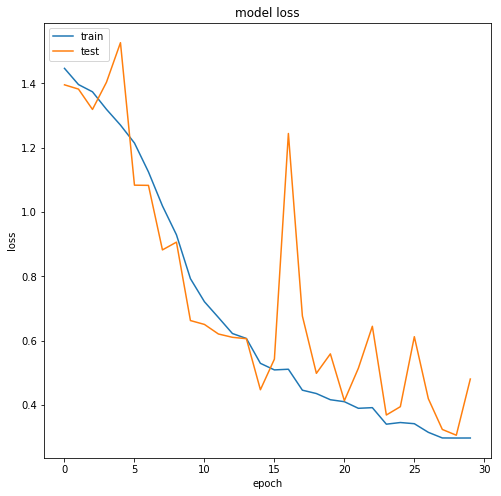

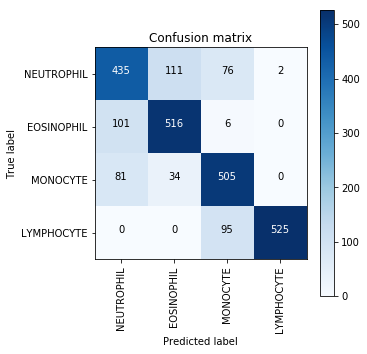

In [39]:
model1, history1 = runKerasCNNAugment(X_train,y_trainHot,X_test,y_testHot,1)

In [27]:
def plot_accuracy_curve(history):
    plt.figure(figsize=(8,8))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    
plot_accuracy_curve(history1)

NameError: name 'history1' is not defined

NameError: name 'model1' is not defined

Epoch 1/30
312/311 [==============================] - 44s 142ms/step - loss: 0.6974 - acc: 0.5305 - val_loss: 0.6838 - val_acc: 0.5895
Epoch 2/30
312/311 [==============================] - 43s 138ms/step - loss: 0.6716 - acc: 0.5900 - val_loss: 0.6261 - val_acc: 0.6429
Epoch 3/30
312/311 [==============================] - 43s 139ms/step - loss: 0.5966 - acc: 0.6770 - val_loss: 0.5053 - val_acc: 0.7041
Epoch 4/30
312/311 [==============================] - 43s 137ms/step - loss: 0.4879 - acc: 0.7658 - val_loss: 0.6337 - val_acc: 0.6498
Epoch 5/30
312/311 [==============================] - 43s 139ms/step - loss: 0.4176 - acc: 0.8047 - val_loss: 0.6444 - val_acc: 0.6494
Epoch 6/30
312/311 [==============================] - 43s 138ms/step - loss: 0.3709 - acc: 0.8336 - val_loss: 0.4630 - val_acc: 0.7905
Epoch 7/30
312/311 [==============================] - 43s 137ms/step - loss: 0.3078 - acc: 0.8676 - val_loss: 0.2376 - val_acc: 0.9075
Epoch 8/30
312/311 [==============================] - 4

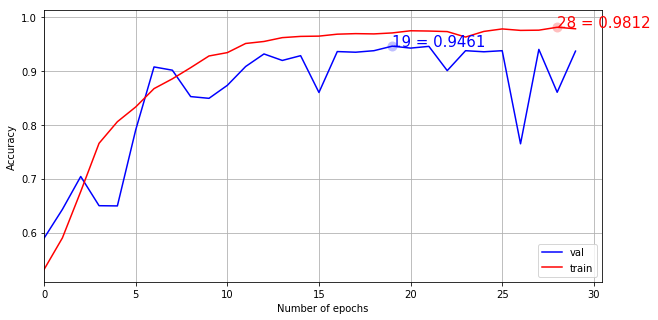

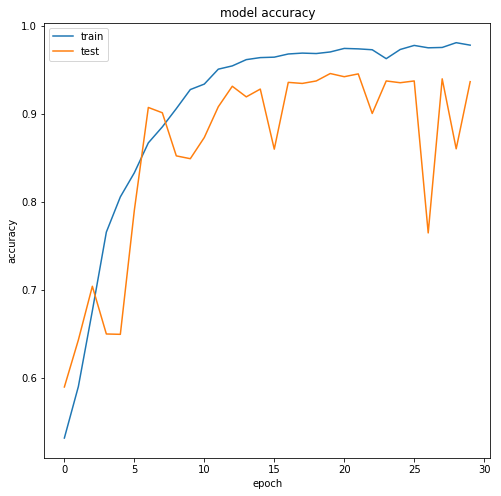

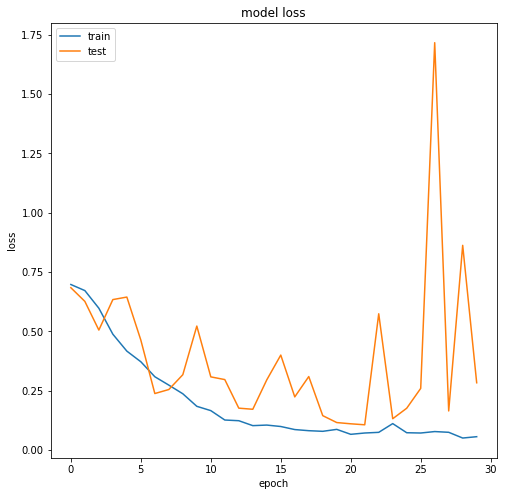

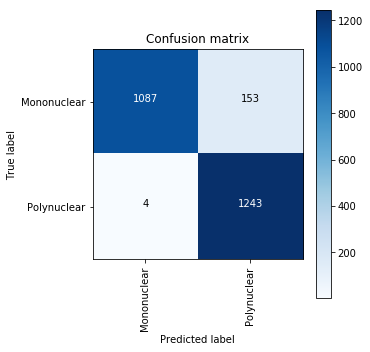

In [41]:
dict_characters = dict_characters2
runKerasCNNAugment(X_train,z_trainHot,X_test,z_testHot,2)   
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}